<a href="https://colab.research.google.com/github/Guptasrijal0901/VS-ScriptKiddies/blob/master/vs_scriptkiddies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow pandas numpy matplotlib scikit-learn svgwrite cairosvg

In [ ]:
!pip install tensorflow pandas numpy matplotlib scikit-learn svgwrite cairosvg

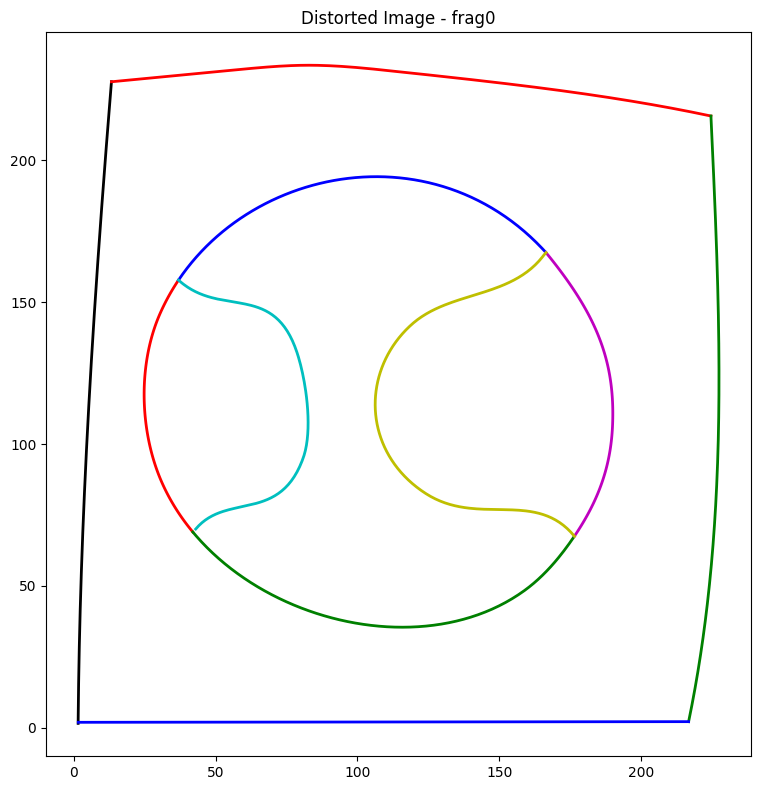

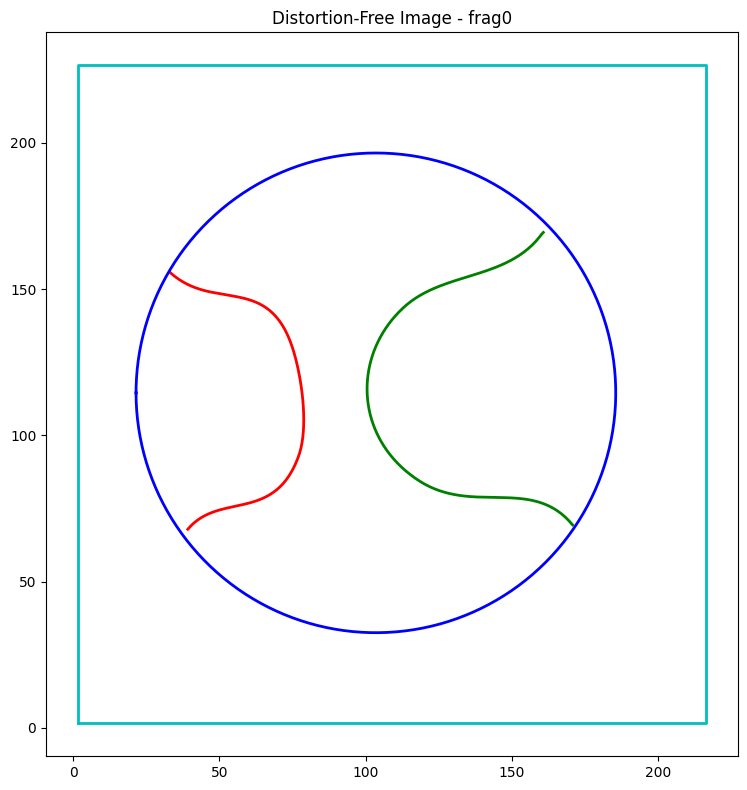

Model score on frag0 test data:  0.47525383091247764


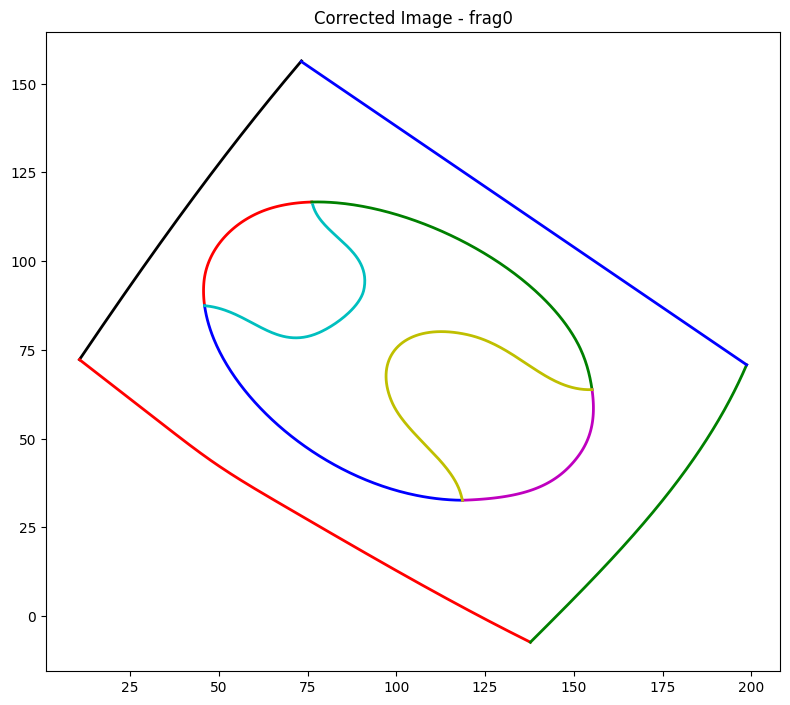

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

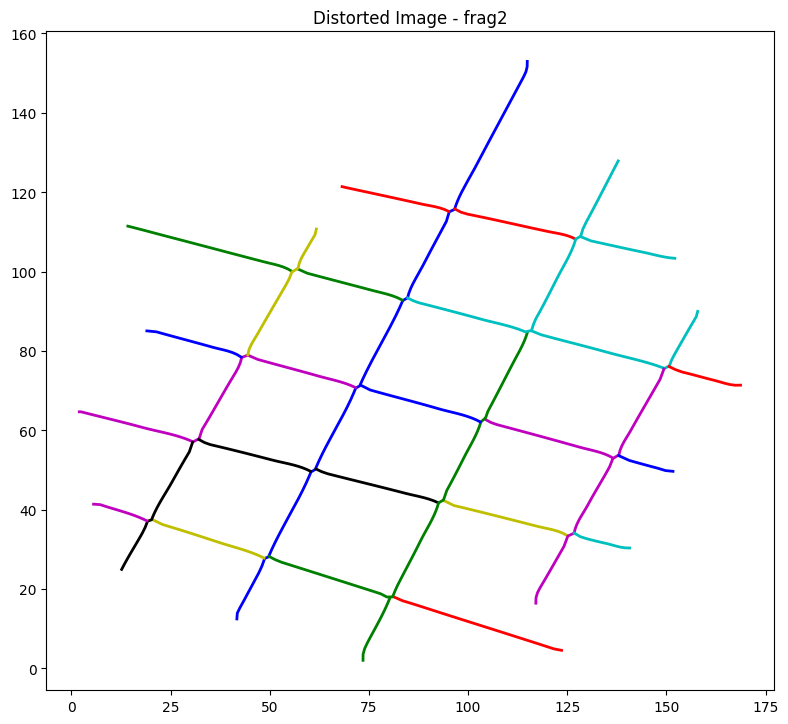

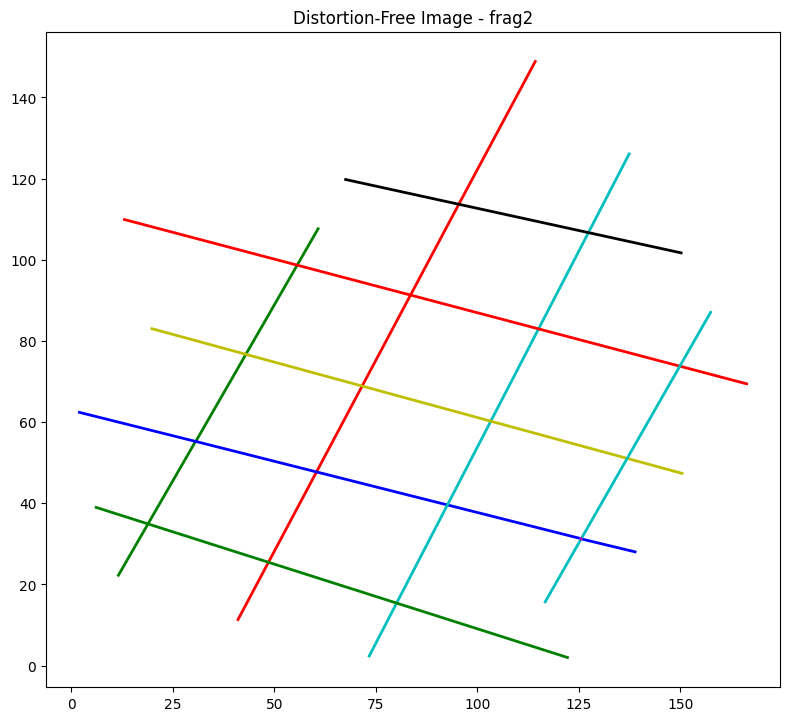

Model score on frag2 test data:  -0.9202640562408186


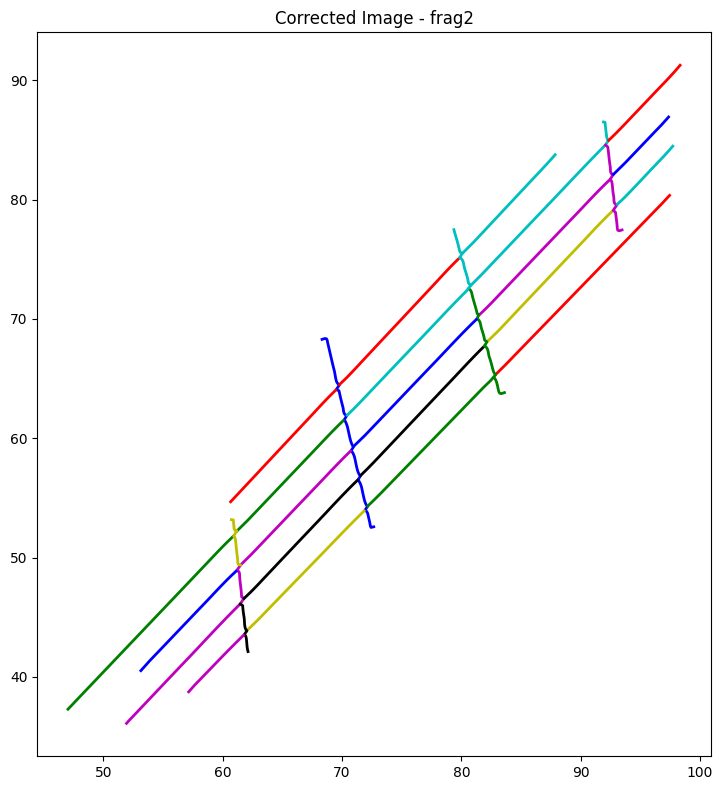

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import svgwrite
import cairosvg

# Function to read CSV files
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Function to plot the curves
def plot(paths_XYs, title='Plot'):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.title(title)
    plt.show()

# Function to prepare training data
def prepare_training_data(distorted_paths, free_paths):
    X, y = [], []
    for d_path, f_path in zip(distorted_paths, free_paths):
        for d_XY, f_XY in zip(d_path, f_path):
            for d_point, f_point in zip(d_XY, f_XY):
                X.append(d_point)
                y.append(f_point)
    return np.array(X), np.array(y)

# Function to apply the model to remove distortion
def remove_distortion(paths_XYs, model):
    new_paths = []
    for path in paths_XYs:
        new_path = []
        for XY in path:
            corrected_XY = model.predict(XY)
            new_path.append(corrected_XY)
        new_paths.append(new_path)
    return new_paths

# Function to compute cubic bezier control points
def cubic_bezier_control_points(points):
    p = np.array(points)
    n = len(p) - 1
    a, b, c, r = [0] * (n+1), [0] * (n+1), [0] * (n+1), [0] * (n+1)

    b[0] = 2
    c[0] = 1
    r[0] = p[0] + 2 * p[1]

    for i in range(1, n-1):
        a[i] = 1
        b[i] = 4
        c[i] = 1
        r[i] = 4 * p[i] + 2 * p[i+1]

    a[n-1] = 2
    b[n-1] = 7
    r[n-1] = 8 * p[n-1] + p[n]

    b[n] = 2
    r[n] = p[n]

    # Solve for control points
    for i in range(1, n+1):
        m = a[i] / b[i-1]
        b[i] -= m * c[i-1]
        r[i] -= m * r[i-1]

    control_points_1 = [0] * (n+1)
    control_points_2 = [0] * n

    control_points_1[n] = r[n] / b[n]
    for i in range(n-1, -1, -1):
        control_points_1[i] = (r[i] - c[i] * control_points_1[i+1]) / b[i]

    for i in range(n):
        control_points_2[i] = 2 * p[i+1] - control_points_1[i+1]

    return control_points_1, control_points_2

# Function to convert paths to cubic bezier curves
def paths_to_bezier(paths):
    bezier_paths = []
    for path in paths:
        bezier_path = []
        for points in path:
            p1, p2 = cubic_bezier_control_points(points)
            bezier_path.append((points, p1, p2))
        bezier_paths.append(bezier_path)
    return bezier_paths

# Function to generate SVG
def generate_svg(bezier_paths, filename='output.svg'):
    dwg = svgwrite.Drawing(filename, profile='tiny')
    for bezier_path in bezier_paths:
        for points, p1, p2 in bezier_path:
            path = dwg.path(d=f'M {points[0][0]},{points[0][1]}', stroke='black', fill='none', stroke_width=2)
            for i in range(1, len(points)):
                path.push(f'C {p1[i-1][0]},{p1[i-1][1]} {p2[i-1][0]},{p2[i-1][1]} {points[i][0]},{points[i][1]}')
            dwg.add(path)
    dwg.save()

# Process for frag0
paths_XYs_frag0 = read_csv('frag0.csv')
plot(paths_XYs_frag0, title='Distorted Image - frag0')

paths_XYs_free_frag0 = read_csv('frag01_sol.csv')
plot(paths_XYs_free_frag0, title='Distortion-Free Image - frag0')

X_frag0, y_frag0 = prepare_training_data(paths_XYs_frag0, paths_XYs_free_frag0)
X_train_frag0, X_test_frag0, y_train_frag0, y_test_frag0 = train_test_split(X_frag0, y_frag0, test_size=0.2, random_state=42)

model_frag0 = LinearRegression()
model_frag0.fit(X_train_frag0, y_train_frag0)
print("Model score on frag0 test data: ", model_frag0.score(X_test_frag0, y_test_frag0))

corrected_paths_frag0 = remove_distortion(paths_XYs_frag0, model_frag0)
plot(corrected_paths_frag0, title='Corrected Image - frag0')

bezier_paths_frag0 = paths_to_bezier(corrected_paths_frag0)
generate_svg(bezier_paths_frag0, filename='frag0_corrected.svg')
files.download('frag0_corrected.svg')

# Process for frag2
paths_XYs_frag2 = read_csv('frag2.csv')
plot(paths_XYs_frag2, title='Distorted Image - frag2')

paths_XYs_free_frag2 = read_csv('frag2_sol.csv')
plot(paths_XYs_free_frag2, title='Distortion-Free Image - frag2')

X_frag2, y_frag2 = prepare_training_data(paths_XYs_frag2, paths_XYs_free_frag2)
X_train_frag2, X_test_frag2, y_train_frag2, y_test_frag2 = train_test_split(X_frag2, y_frag2, test_size=0.2, random_state=42)

model_frag2 = LinearRegression()
model_frag2.fit(X_train_frag2, y_train_frag2)
print("Model score on frag2 test data: ", model_frag2.score(X_test_frag2, y_test_frag2))

corrected_paths_frag2 = remove_distortion(paths_XYs_frag2, model_frag2)
plot(corrected_paths_frag2, title='Corrected Image - frag2')

bezier_paths_frag2 = paths_to_bezier(corrected_paths_frag2)
generate_svg(bezier_paths_frag2, filename='corrected.svg')
files.download('corrected.svg')


Model training completed.
Model score on test data:  0.4533003023851569


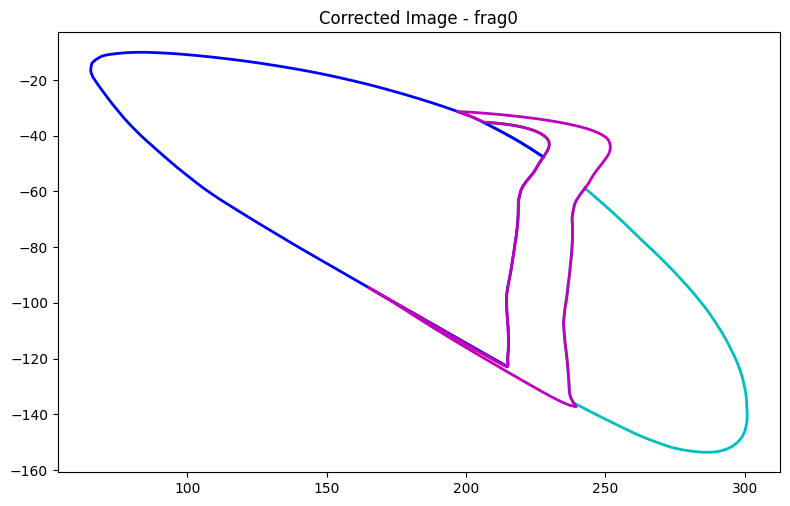

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from google.colab import files

# Function to read CSV files
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Function to prepare training data
def prepare_training_data(distorted_paths, free_paths):
    X, y = [], []
    for d_path, f_path in zip(distorted_paths, free_paths):
        for d_XY, f_XY in zip(d_path, f_path):
            for d_point, f_point in zip(d_XY, f_XY):
                X.append(d_point)
                y.append(f_point)
    return np.array(X), np.array(y)

# Function to plot the curves with Y-axis inversion
def plot(paths_XYs, title='Plot'):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], -XY[:, 1], c=c, linewidth=2)  # Inverting Y-axis for visualization
    ax.set_aspect('equal')
    plt.title(title)
    plt.show()

# Function to apply the model to remove distortion
def remove_distortion(paths_XYs, model):
    new_paths = []
    for path in paths_XYs:
        new_path = []
        for XY in path:
            corrected_XY = model.predict(XY)
            new_path.append(corrected_XY)
        new_paths.append(new_path)
    return new_paths

# Function to convert paths to cubic bezier curves
def cubic_bezier_control_points(points):
    p = np.array(points)
    n = len(p) - 1
    a, b, c, r = [0] * (n+1), [0] * (n+1), [0] * (n+1), [0] * (n+1)

    b[0] = 2
    c[0] = 1
    r[0] = p[0] + 2 * p[1]

    for i in range(1, n-1):
        a[i] = 1
        b[i] = 4
        c[i] = 1
        r[i] = 4 * p[i] + 2 * p[i+1]

    a[n-1] = 2
    b[n-1] = 7
    r[n-1] = 8 * p[n-1] + p[n]

    b[n] = 2
    r[n] = p[n]

    # Solve for control points
    for i in range(1, n+1):
        m = a[i] / b[i-1]
        b[i] -= m * c[i-1]
        r[i] -= m * r[i-1]

    control_points_1 = [0] * (n+1)
    control_points_2 = [0] * n

    control_points_1[n] = r[n] / b[n]
    for i in range(n-1, -1, -1):
        control_points_1[i] = (r[i] - c[i] * control_points_1[i+1]) / b[i]

    for i in range(n):
        control_points_2[i] = 2 * p[i+1] - control_points_1[i+1]

    return np.array(control_points_1), np.array(control_points_2)  # Convert to numpy arrays

# Function to convert paths to cubic bezier curves
def paths_to_bezier(paths):
    bezier_paths = []
    for path in paths:
        bezier_path = []
        for points in path:
            p1, p2 = cubic_bezier_control_points(points)
            bezier_path.append((points, p1, p2))
        bezier_paths.append(bezier_path)
    return bezier_paths

# Function to generate SVG
def generate_svg(bezier_paths, filename='output.svg', height=500):
    dwg = svgwrite.Drawing(filename, profile='tiny', height=height)
    for bezier_path in bezier_paths:
        for points, p1, p2 in bezier_path:
            # Convert to numpy arrays
            points = np.array(points)
            p1 = np.array(p1)
            p2 = np.array(p2)

            # Create the SVG path without inverting Y-coordinates
            path = dwg.path(d=f'M {points[0][0]},{points[0][1]}', stroke='black', fill='none', stroke_width=2)
            for i in range(1, len(points)):
                path.push(f'C {p1[i-1][0]},{p1[i-1][1]} {p2[i-1][0]},{p2[i-1][1]} {points[i][0]},{points[i][1]}')
            dwg.add(path)
    dwg.save()

# Load and prepare data
paths_XYs_distorted = read_csv('occlusion2.csv')
paths_XYs_solution = read_csv('occlusion2_sol.csv')
X, y = prepare_training_data(paths_XYs_distorted, paths_XYs_solution)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Output the model's performance
print("Model training completed.")
print("Model score on test data: ", model.score(X_test, y_test))

# Apply the model to the distorted data
corrected_paths = remove_distortion(paths_XYs_distorted, model)
plot(corrected_paths, title='Corrected Image - frag0')

# Convert corrected paths to Bezier curves and generate SVG
bezier_paths = paths_to_bezier(corrected_paths)
generate_svg(bezier_paths, filename='corrected.svg', height=500)

# Automatically download the generated SVG files
files.download('corrected.svg')


Model training completed.
Model score on test data:  0.890472730441958


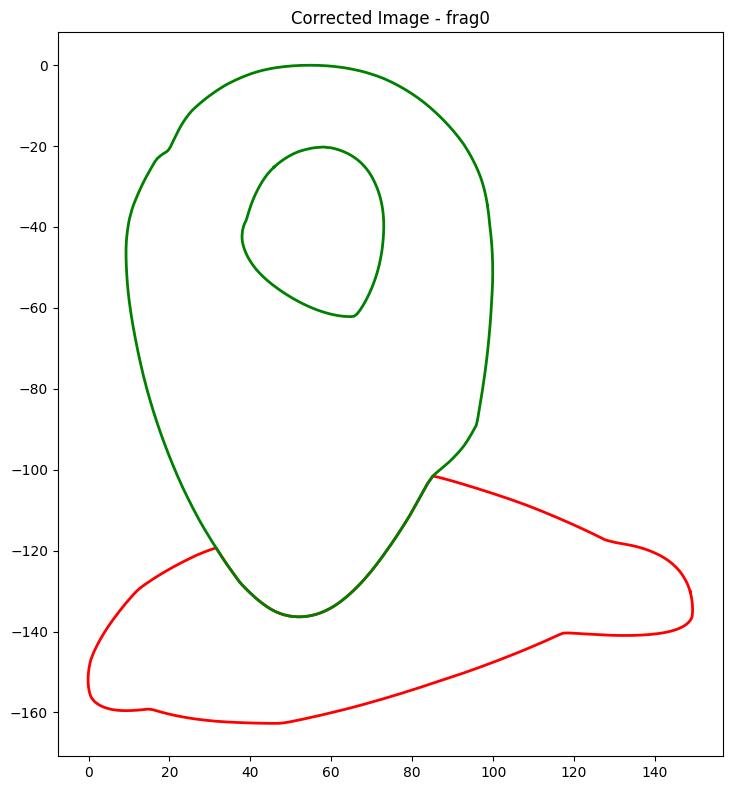

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from google.colab import files

# Function to read CSV files
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Function to prepare training data
def prepare_training_data(distorted_paths, free_paths):
    X, y = [], []
    for d_path, f_path in zip(distorted_paths, free_paths):
        for d_XY, f_XY in zip(d_path, f_path):
            for d_point, f_point in zip(d_XY, f_XY):
                X.append(d_point)
                y.append(f_point)
    return np.array(X), np.array(y)

# Function to plot the curves with Y-axis inversion
def plot(paths_XYs, title='Plot'):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], -XY[:, 1], c=c, linewidth=2)  # Inverting Y-axis for visualization
    ax.set_aspect('equal')
    plt.title(title)
    plt.show()

# Function to apply the model to remove distortion
def remove_distortion(paths_XYs, model):
    new_paths = []
    for path in paths_XYs:
        new_path = []
        for XY in path:
            corrected_XY = model.predict(XY)
            new_path.append(corrected_XY)
        new_paths.append(new_path)
    return new_paths

# Function to convert paths to cubic bezier curves
def cubic_bezier_control_points(points):
    p = np.array(points)
    n = len(p) - 1
    a, b, c, r = [0] * (n+1), [0] * (n+1), [0] * (n+1), [0] * (n+1)

    b[0] = 2
    c[0] = 1
    r[0] = p[0] + 2 * p[1]

    for i in range(1, n-1):
        a[i] = 1
        b[i] = 4
        c[i] = 1
        r[i] = 4 * p[i] + 2 * p[i+1]

    a[n-1] = 2
    b[n-1] = 7
    r[n-1] = 8 * p[n-1] + p[n]

    b[n] = 2
    r[n] = p[n]

    # Solve for control points
    for i in range(1, n+1):
        m = a[i] / b[i-1]
        b[i] -= m * c[i-1]
        r[i] -= m * r[i-1]

    control_points_1 = [0] * (n+1)
    control_points_2 = [0] * n

    control_points_1[n] = r[n] / b[n]
    for i in range(n-1, -1, -1):
        control_points_1[i] = (r[i] - c[i] * control_points_1[i+1]) / b[i]

    for i in range(n):
        control_points_2[i] = 2 * p[i+1] - control_points_1[i+1]

    return np.array(control_points_1), np.array(control_points_2)  # Convert to numpy arrays

# Function to convert paths to cubic bezier curves
def paths_to_bezier(paths):
    bezier_paths = []
    for path in paths:
        bezier_path = []
        for points in path:
            p1, p2 = cubic_bezier_control_points(points)
            bezier_path.append((points, p1, p2))
        bezier_paths.append(bezier_path)
    return bezier_paths

# Function to generate SVG
def generate_svg(bezier_paths, filename='output.svg', height=500):
    dwg = svgwrite.Drawing(filename, profile='tiny', height=height)
    for bezier_path in bezier_paths:
        for points, p1, p2 in bezier_path:
            # Convert to numpy arrays
            points = np.array(points)
            p1 = np.array(p1)
            p2 = np.array(p2)

            # Create the SVG path without inverting Y-coordinates
            path = dwg.path(d=f'M {points[0][0]},{points[0][1]}', stroke='black', fill='none', stroke_width=2)
            for i in range(1, len(points)):
                path.push(f'C {p1[i-1][0]},{p1[i-1][1]} {p2[i-1][0]},{p2[i-1][1]} {points[i][0]},{points[i][1]}')
            dwg.add(path)
    dwg.save()

# Load and prepare data
paths_XYs_distorted = read_csv('occlusion1.csv')
paths_XYs_solution = read_csv('occlusion1_sol.csv')
X, y = prepare_training_data(paths_XYs_distorted, paths_XYs_solution)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Output the model's performance
print("Model training completed.")
print("Model score on test data: ", model.score(X_test, y_test))

# Apply the model to the distorted data
corrected_paths = remove_distortion(paths_XYs_distorted, model)
plot(corrected_paths, title='Corrected Image - frag0')

# Convert corrected paths to Bezier curves and generate SVG
bezier_paths = paths_to_bezier(corrected_paths)
generate_svg(bezier_paths, filename='frag0_corrected.svg', height=500)

# Automatically download the generated SVG files
files.download('frag0_corrected.svg')
